In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
toxprot_17 = pd.read_csv("../data/processed/toxprot_2017.csv")
toxprot_25 = pd.read_csv("../data/processed/toxprot_2025.csv")

In [18]:
toxprot_25["Protein families"].value_counts()[:15]

Protein families
Phospholipase A2 family                             543
Snake three-finger toxin family                     536
Long (4 C-C) scorpion toxin superfamily             426
Neurotoxin 10 (Hwtx-1) family                       290
Venom metalloproteinase (M12B) family               286
Conotoxin O1 superfamily                            281
Short scorpion toxin superfamily                    274
Venom Kunitz-type family                            261
Peptidase S1 family                                 232
Arthropod phospholipase D family                    220
Conotoxin A superfamily                             186
Neurotoxin 19 (CSTX) family                         185
Conotoxin M superfamily                             183
Snaclec family                                      183
Non-disulfide-bridged peptide (NDBP) superfamily    168
Name: count, dtype: int64

In [4]:
toxprot_17["Fragment"].value_counts(dropna=False)

Fragment
NaN         5539
fragment    1164
Name: count, dtype: int64

In [5]:
toxprot_25["Protein families"].value_counts()

Protein families
Phospholipase A2 family                    543
Snake three-finger toxin family            536
Long (4 C-C) scorpion toxin superfamily    426
Neurotoxin 10 (Hwtx-1) family              290
Venom metalloproteinase (M12B) family      286
                                          ... 
Scolopendra toxin 9 family                   1
ATP:guanido phosphotransferase family        1
Diapausin family                             1
DNase II family                              1
SLPTX(15) family                             1
Name: count, Length: 304, dtype: int64

### Figures

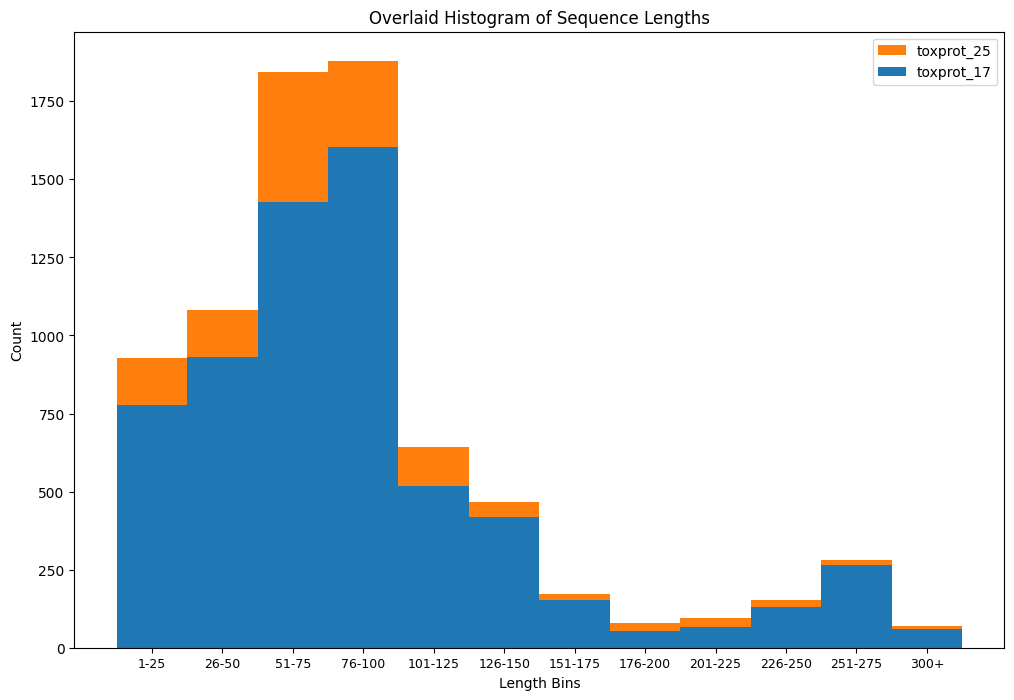

In [6]:
bins = np.arange(1, 325, 25)

bin_labels = [f"{start}-{end - 1}" for start, end in zip(bins[:-1], bins[1:])]
bin_labels[-1] = "300+"

lengths_25 = toxprot_25["Length"]
lengths_17 = toxprot_17["Length"]

plt.figure(figsize=(12, 8))
plt.hist(lengths_25, bins=bins, color=plt.cm.tab10(1), label="toxprot_25")
plt.hist(lengths_17, bins=bins, color=plt.cm.tab10(0), label="toxprot_17")

plt.xlabel("Length Bins")
plt.ylabel("Count")
plt.title("Overlaid Histogram of Sequence Lengths")

plt.xticks(bins[:-1] + 12.5, bin_labels, fontsize=9)

plt.legend()
plt.savefig("../figures/overlaid_hist.png", dpi=300)

plt.show()
plt.close()

In [7]:
toxprot_17["Fragment"].value_counts()

Fragment
fragment    1164
Name: count, dtype: int64

In [8]:
na_count_17 = toxprot_17["Protein families"].isna().sum()  # Count NaN values
total_count_17 = len(toxprot_17["Protein families"])  # Total number of entries
na_percentage_17 = (
    (na_count_17 / total_count_17) * 100 if total_count_17 > 0 else 0
)  # Calculate percentage
unique_families_17 = len(toxprot_17["Protein families"].dropna().unique())

print(f"N/A (NaN) Count: {na_count_17}")
print(f"{unique_families_17}")
print(f"N/A (NaN) Percentage: {na_percentage_17:.2f}%")

na_count_25 = toxprot_25["Protein families"].isna().sum()  # Count NaN values
total_count_25 = len(toxprot_25["Protein families"])  # Total number of entries
na_percentage_25 = (
    (na_count_25 / total_count_25) * 100 if total_count_25 > 0 else 0
)  # Calculate percentage
unique_families_25 = len(toxprot_25["Protein families"].dropna().unique())

print(f"N/A (NaN) Count: {na_count_25}")
print(f"{unique_families_25}")
print(f"N/A (NaN) Percentage: {na_percentage_25:.2f}%")


N/A (NaN) Count: 584
193
N/A (NaN) Percentage: 8.71%
N/A (NaN) Count: 591
304
N/A (NaN) Percentage: 7.34%


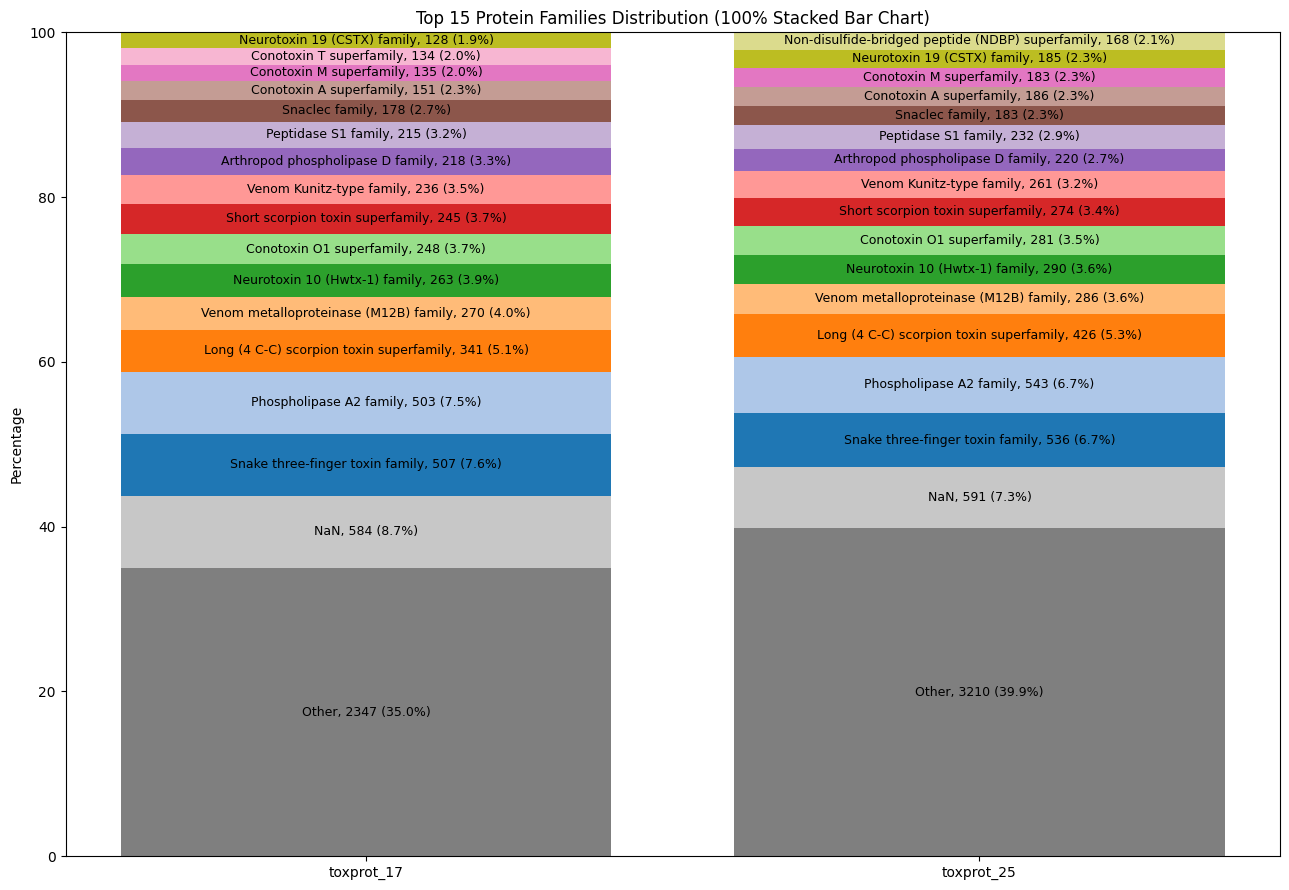

In [24]:
def get_top_families_per_dataset(df, column, top_n=15):
    counts = df[column].value_counts()
    top_counts = counts.nlargest(top_n)
    other_count = counts.iloc[top_n:].sum()
    nan_count = df[column].isna().sum()

    result_series = top_counts.copy()
    if other_count > 0:
        result_series["Other"] = other_count
    if nan_count > 0:
        result_series["NaN"] = nan_count
    return result_series


TOP_N_FAMILIES = 15

name_map_2017_to_2025 = {
    "Huwentoxin-1 family": "Neurotoxin 10 (Hwtx-1) family",
    "Spider toxin CSTX superfamily": "Neurotoxin 19 (CSTX) family",
}

top_17 = get_top_families_per_dataset(
    toxprot_17, "Protein families", top_n=TOP_N_FAMILIES
)
top_25 = get_top_families_per_dataset(
    toxprot_25, "Protein families", top_n=TOP_N_FAMILIES
)

top_17_sorted = top_17.sort_values(ascending=False)
top_25_sorted = top_25.sort_values(ascending=False)

ordered_families = []
seen_canonical_families = set()

for fam17_original in top_17_sorted.index:
    canonical_name = name_map_2017_to_2025.get(fam17_original, fam17_original)
    if canonical_name not in seen_canonical_families:
        ordered_families.append(canonical_name)
        seen_canonical_families.add(canonical_name)

for fam25_canonical in top_25_sorted.index:
    if fam25_canonical not in seen_canonical_families:
        ordered_families.append(fam25_canonical)
        seen_canonical_families.add(fam25_canonical)
all_families = ordered_families


df_stacked = pd.DataFrame(index=all_families)

top_17_renamed = top_17.rename(index=name_map_2017_to_2025)
df_stacked["toxprot_17"] = top_17_renamed.reindex(all_families).fillna(0)
df_stacked["toxprot_25"] = top_25.reindex(all_families).fillna(0)

df_stacked_perc = df_stacked.div(df_stacked.sum(axis=0), axis=1) * 100
df_stacked_perc = df_stacked_perc.fillna(0)

colors_cmap = plt.colormaps["tab20"]
color_map = {}

color_map["Other"] = colors_cmap(14)
color_map["NaN"] = colors_cmap(15)

palette_for_families = [
    c for i, c in enumerate(colors_cmap.colors) if i not in [14, 15]
]

families_no_nan_other = [f for f in all_families if f not in ("Other", "NaN")]

for i, family_name in enumerate(families_no_nan_other):
    if i < len(palette_for_families):
        color_map[family_name] = palette_for_families[i]
    else:
        # Fallback: Cycles through palette if more families than unique colors.
        color_map[family_name] = palette_for_families[i % len(palette_for_families)]


fig, ax = plt.subplots(figsize=(13, 9))

bars_info = []
bottom17 = 0
for fam in all_families:
    pct = df_stacked_perc.at[fam, "toxprot_17"]
    cnt = df_stacked.at[fam, "toxprot_17"]
    if cnt > 0:
        bar = ax.bar(
            "toxprot_17",
            pct,
            bottom=bottom17,
            color=color_map.get(fam, "gray"),
        )[0]
        bars_info.append({"bar": bar, "fam": fam, "cnt": cnt, "pct": pct})
    bottom17 += pct

bottom25 = 0
for fam in all_families:
    pct = df_stacked_perc.at[fam, "toxprot_25"]
    cnt = df_stacked.at[fam, "toxprot_25"]
    if cnt > 0:
        bar = ax.bar(
            "toxprot_25",
            pct,
            bottom=bottom25,
            color=color_map.get(fam, "gray"),
        )[0]
        bars_info.append({"bar": bar, "fam": fam, "cnt": cnt, "pct": pct})
    bottom25 += pct

for item in bars_info:
    bar, fam, cnt, pct = item["bar"], item["fam"], item["cnt"], item["pct"]
    if pct > 1.0:  # Threshold for displaying label
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_y() + bar.get_height() / 2,
            f"{fam}, {int(cnt)} ({pct:.1f}%)",
            ha="center",
            va="center",
            fontsize=9,
            wrap=True,
        )

ax.set_ylabel("Percentage")
ax.set_title(
    f"Top {TOP_N_FAMILIES} Protein Families Distribution (100% Stacked Bar Chart)"
)
ax.set_ylim(0, 100)
ax.tick_params(axis="x", labelsize=10)
ax.tick_params(axis="y", labelsize=10)

plt.tight_layout()
plt.savefig("../figures/stacked_bar_protfam.png", dpi=300)
plt.show()
plt.close()

In [10]:
# Ensure the 'Fragment' column is treated as a string
toxprot_17["Fragment"] = toxprot_17["Fragment"].astype(str)
toxprot_25["Fragment"] = toxprot_25["Fragment"].astype(str)

# Count occurrences of "fragment" (case-insensitive)
fragment_count_17 = (
    toxprot_17["Fragment"].str.contains("fragment", case=False, na=False).sum()
)
total_count_17 = toxprot_17.shape[0]
fragment_percentage_17 = (
    (fragment_count_17 / total_count_17) * 100 if total_count_17 > 0 else 0
)

print(f"Fragment Count 17: {fragment_count_17}")
print(f"Fragment Percentage 17: {fragment_percentage_17:.2f}%")

fragment_count_25 = (
    toxprot_25["Fragment"].str.contains("fragment", case=False, na=False).sum()
)
total_count_25 = toxprot_25.shape[0]
fragment_percentage_25 = (
    (fragment_count_25 / total_count_25) * 100 if total_count_25 > 0 else 0
)

print(f"Fragment Count 25: {fragment_count_25}")
print(f"Fragment Percentage 25: {fragment_percentage_25:.2f}%")

Fragment Count 17: 1164
Fragment Percentage 17: 17.37%
Fragment Count 25: 1300
Fragment Percentage 25: 16.14%


In [11]:
# Count occurrences where PTM is not NaN
ptm_count_17 = toxprot_17["PTM"].notna().sum()
ptm_percentage_17 = (ptm_count_17 / total_count_17) * 100 if total_count_17 > 0 else 0

print(f"ptm Count (2017): {ptm_count_17}")
print(f"ptm Percentage (2017): {ptm_percentage_17:.2f}%")

# Count occurrences where PTM is not NaN in 2025 datap
ptm_count_25 = toxprot_25["PTM"].notna().sum()
ptm_percentage_25 = (ptm_count_25 / total_count_25) * 100 if total_count_25 > 0 else 0

print(f"ptm Count (2025): {ptm_count_25}")
print(f"ptm Percentage (2025): {ptm_percentage_25:.2f}%")

ptm Count (2017): 964
ptm Percentage (2017): 14.38%
ptm Count (2025): 1380
ptm Percentage (2025): 17.13%


In [12]:
# Count occurrences where toxic is not NaN
toxic_count_17 = toxprot_17["Toxic dose"].notna().sum()
toxic_percentage_17 = (
    (toxic_count_17 / total_count_17) * 100 if total_count_17 > 0 else 0
)

print(f"toxic Count (2017): {toxic_count_17}")
print(f"toxic Percentage (2017): {toxic_percentage_17:.2f}%")

# Count occurrences where toxic is not NaN in 2025 data
toxic_count_25 = toxprot_25["Toxic dose"].notna().sum()
toxic_percentage_25 = (
    (toxic_count_25 / total_count_25) * 100 if total_count_25 > 0 else 0
)

print(f"Toxic dose Count (2025): {toxic_count_25}")
print(f"PTM Percentage (2025): {toxic_percentage_25:.2f}%")

toxic Count (2017): 584
toxic Percentage (2017): 8.71%
Toxic dose Count (2025): 680
PTM Percentage (2025): 8.44%


In [13]:
len(toxprot_17["Species"].value_counts())

706

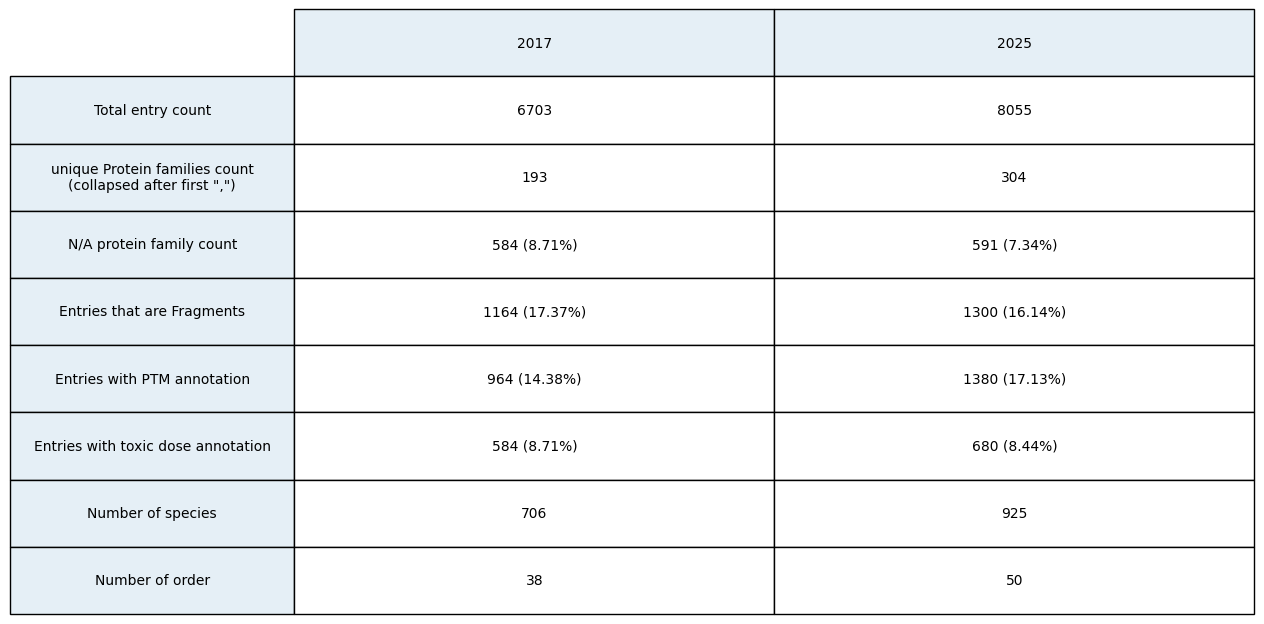

In [14]:
cell_text = [
    [total_count_17, total_count_25],
    [unique_families_17, unique_families_25],
    [
        f"{na_count_17} ({na_percentage_17:.2f}%)",
        f"{na_count_25} ({na_percentage_25:.2f}%)",
    ],
    [
        f"{fragment_count_17} ({fragment_percentage_17:.2f}%)",
        f"{fragment_count_25} ({fragment_percentage_25:.2f}%)",
    ],
    [
        f"{ptm_count_17} ({ptm_percentage_17:.2f}%)",
        f"{ptm_count_25} ({ptm_percentage_25:.2f}%)",
    ],
    [
        f"{toxic_count_17} ({toxic_percentage_17:.2f}%)",
        f"{toxic_count_25} ({toxic_percentage_25:.2f}%)",
    ],
    [
        len(toxprot_17["Species"].unique()),
        len(toxprot_25["Species"].unique()),
    ],
    [len(toxprot_17["Order"].unique()), len(toxprot_25["Order"].unique())],
]
row_headers = [
    "Total entry count",
    'unique Protein families count\n(collapsed after first ",")',
    "N/A protein family count",
    "Entries that are Fragments",
    "Entries with PTM annotation",
    "Entries with toxic dose annotation",
    "Number of species",
    "Number of order",
]
column_headers = ["2017", "2025"]

rcolors = plt.cm.BuPu(np.full(len(row_headers), 0.1))
ccolors = plt.cm.BuPu(np.full(len(column_headers), 0.1))

fig, ax = plt.subplots(figsize=(12, 6))
ax.axis("tight")
ax.axis("off")

the_table = plt.table(
    cellText=cell_text,
    rowLabels=row_headers,
    rowColours=rcolors,
    rowLoc="center",
    colColours=ccolors,
    colLabels=column_headers,
    cellLoc="center",
    loc="center",
)

table_props = the_table.properties()
cells = table_props["children"]
for cell in cells:
    cell.set_height(0.14)

for cell in cells:
    cell.set_fontsize(10)

for i, key in enumerate(the_table._cells):
    if key[0] == 0:  # Column labels
        the_table._cells[key].set_fontsize(15)
    if key[1] == 0:  # Row labels
        the_table._cells[key].set_fontsize(15)

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

plt.savefig("../figures/table.png", dpi=300, bbox_inches="tight")
plt.show()

In [15]:
# import numpy as np
# import pandas as pd
# import plotly.graph_objects as go
# from pathlib import Path
#
# # Ensure output folder exists
# OUT = Path("out")
# OUT.mkdir(exist_ok=True)
#
# # 1) Load & extract primary families
# tox17 = pd.read_csv("../data/processed/toxprot_2017.csv")
# tox25 = pd.read_csv("../data/processed/toxprot_2025.csv")
#
# tox17["Family_2017"] = (
#     tox17["Protein families"].fillna("")
#          .str.split(r"\.", n=1, regex=True).str[0]
# )
# tox25["Family_2025"] = (
#     tox25["Protein families"].fillna("")
#          .str.split(r"[,;]", n=1, regex=True).str[0]
# )
#
# # 2) Merge on Entry (inner join)
# df17 = tox17[["Entry","Family_2017"]]
# df25 = tox25[["Entry","Family_2025"]]
# merged = pd.merge(df17, df25, on="Entry", how="inner")
#
# # 3) Count every transition (self‐flows included)
# flows = (
#     merged
#       .groupby(["Family_2017","Family_2025"])
#       .size()
#       .reset_index(name="value")
# )
#
# # 4) Find global top-10 in each year
# counts_17 = merged["Family_2017"].value_counts()
# counts_25 = merged["Family_2025"].value_counts()
# top10_17  = counts_17.nlargest(10).index.tolist()
# top10_25  = counts_25.nlargest(10).index.tolist()
#
# # 5) Bin into top-10 / Other / nan
# def bin_family(x, top10, tag):
#     if x == "" or pd.isna(x):
#         return f"nan ({tag})"
#     if x in top10:
#         return x
#     return f"Other ({tag})"
#
# flows["old_bin"] = flows["Family_2017"].apply(lambda x: bin_family(x, top10_17, "2017"))
# flows["new_bin"] = flows["Family_2025"].apply(lambda x: bin_family(x, top10_25, "2025"))
#
# binned = (
#     flows
#       .groupby(["old_bin","new_bin"])["value"]
#       .sum()
#       .reset_index()
# )
#
# # 6) Build node list (old on left, new on right)
# old_nodes = top10_17 + ["Other (2017)", "nan (2017)"]
# new_nodes = top10_25 + ["Other (2025)", "nan (2025)"]
# labels   = old_nodes + new_nodes
# idx_map  = {lab: i for i, lab in enumerate(labels)}
#
# binned["source"] = binned["old_bin"].map(idx_map)
# binned["target"] = binned["new_bin"].map(idx_map)
#
# # 7) Compute even y-positions for each node
# n_left  = len(old_nodes)
# n_right = len(new_nodes)
# y_left  = np.linspace(0, 1, n_left)
# y_right = np.linspace(0, 1, n_right)
# node_x  = [0.0]*n_left + [1.0]*n_right
# node_y  = np.concatenate([y_left, y_right]).tolist()
#
# # 8) Create the Sankey with fixed arrangement
# fig = go.Figure(go.Sankey(
#     arrangement="fixed",
#     orientation="h",
#     node=dict(
#         label=labels,
#         x=node_x,
#         y=node_y,
#         pad=10,
#         thickness=30,
#         line=dict(color="black", width=0.5),
#     ),
#     link=dict(
#         source=binned["source"],
#         target=binned["target"],
#         value=binned["value"],
#         color='rgba(0,0,0,0.2)',        # light‐gray fill
#         line=dict(color="black", width=0.5),
#     )
# ))
#
# # 9) Bump fonts for print
# fig.update_layout(
#     title_text="Protein-family flows, 2017 → 2025 (top-10 bins)",
#     font=dict(size=14, family="Arial"),
#     title_font_size=18,
#     width=1200,
#     height=800,
#     margin=dict(l=50, r=50, t=80, b=50),
# )
#
# # Show interactive for quick check
# fig.show()
#
# print(f"Static Sankey exported to: {OUT/'sankey_static.png'}")
